In [1]:
import numpy as np
import joypy
from matplotlib import pyplot as plt
from matplotlib import cm

from scipy import ndimage as ndi
from scipy.spatial import distance

from skimage import io
from skimage.color import rgb2gray
from scipy import ndimage
from skimage import filters
from skimage.morphology import disk, ball

from PIL import Image, ImageDraw, ImageFilter,ImageOps
import copy
import cv2

%load_ext cython

In [2]:
grain1_name='Ultra_Co6_2-040.jpg'
grain2_name='Ultra_Co11-2.jpg'
grain3_name='Ultra_Co25-1.jpg'

path='images'

grain1_pil=Image.open(path+'/'+grain1_name)
grain2_pil=Image.open(path+'/'+grain2_name)
grain3_pil=Image.open(path+'/'+grain3_name)

In [3]:
def img_show(image,N=20,cmap=plt.cm.nipy_spectral):
    
    plt.figure(figsize=(N,N))
    plt.axis('off')
    plt.imshow(image,cmap=cmap)
    plt.show()

def imdivide(image,side):
    
    width,height = image.size
    sides={'left':0,'right':1}
    shape=[(0,0,width//2,height),(width//2,0,width,height)]
    return image.crop(shape[sides[side]])

def combine(image,k=0.5,N=20): 
    left_img=imdivide(image,'left')
    right_img=imdivide(image,'right')

    l=k
    r=1-l
    gray=np.array(left_img)*l
    gray+=np.array(right_img)*r
    gray=gray.astype('uint8')
    return gray

def do_otsu(img,N=20):
    image=rgb2gray(img)
    
    global_thresh=filters.threshold_otsu(image)
    binary_global = image > global_thresh
    
    return binary_global

## Выделение пустот

denoised=mean_filter(image)

binary=otsu(denoised)

grad=gradient(binary)

bin_grad=-binary+grad

In [4]:
combined1=combine(grain1_pil,0.5,10)
combined2=combine(grain2_pil,0.5,10)
combined3=combine(grain3_pil,0.5,10)

denoised1 = filters.rank.median(combined1, disk(3))
denoised2 = filters.rank.median(combined2, disk(3))
denoised3 = filters.rank.median(combined3, disk(3))

binary1=do_otsu(denoised1).astype('uint8')
binary2=do_otsu(denoised2).astype('uint8')
binary3=do_otsu(denoised3).astype('uint8')

grad1 = filters.rank.gradient(binary1, disk(1))
grad2 = filters.rank.gradient(binary2, disk(1))
grad3 = filters.rank.gradient(binary3, disk(1))

# у зерен значение пикселя - 0, у тела пустоты - 1, у границы пустоты - 2
bin_grad1=1-binary1+grad1
bin_grad2=1-binary2+grad2
bin_grad3=1-binary3+grad3

image1=(bin_grad1>0).astype('uint8')*255
image2=(bin_grad2>0).astype('uint8')*255
image3=(bin_grad3>0).astype('uint8')*255

C:\Users\Администратор\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:27: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


In [ ]:
#io.imsave('bin_grad.png',image)

## Маркировка углов

http://espressocode.top/python-corner-detection-with-shi-tomasi-corner-detection-method-using-opencv/

classes - каждому пикселю дается свой класс, по картинке гуляет матрица свертки

In [5]:
def mark_corners(image):
    image=copy.copy(image)
    corners = cv2.goodFeaturesToTrack(image, 1000000, 0.01, 10)

    corners = np.int0(corners)
    print('number of corners: ',len(corners))
    for i in corners:
        x, y = i.ravel()
        cv2.circle(image, (x, y), 3, 255, -1)
    x=copy.copy(corners[:,0,1])
    y=copy.copy(corners[:,0,0])
    corners[:,0,0],corners[:,0,1]=x,y
    return image,corners.astype('int64')

def mark_classes(image):
    classes = filters.rank.gradient(image, disk(1)) < 250
    classes,num = ndi.label(classes)
    print('number of classes:',num)
    return classes,num

In [6]:
grain1_marked,grain1_corners=mark_corners(image1)
grain2_marked,grain2_corners=mark_corners(image2)
grain3_marked,grain3_corners=mark_corners(image3)

grain1_classes,class1_num=mark_classes(image1)
grain2_classes,class2_num=mark_classes(image2)
grain3_classes,class3_num=mark_classes(image3)

number of corners:  321
number of corners:  2727
number of corners:  6174
number of classes: 196
number of classes: 342
number of classes: 1244


## Дадим каждой вершине привязку к пустоте

In [7]:
def join_corners2classes(classes,classes_num,corners,max_corners_per_class):

    shape=(classes_num+1,max_corners_per_class)
    nodes=np.zeros(shape,dtype='int64')
    r=2
    num1=0
    num0=0
    for i,corner in enumerate(corners):
        x=corner[0][0]
        y=corner[0][1]
        cls=classes[x,y]
        real_cls=0
        flag=True
        x_lin=range(x-r,x+r)
        y_lin=range(y-r,y+r)
        while flag:
            for xi in range(x-r,x+r):
                for yi in y_lin:
                    if classes[xi,yi]!=0 and classes[xi,yi]!=1 and classes[xi,yi]!=2:
                        real_cls=classes[xi,yi]
                        flag=False
                    elif yi==y_lin[-1] and xi==x_lin[-1]:
                        flag=False
                        
        
        index=np.where(nodes[real_cls]==0)[0][0]
        nodes[real_cls,index]=i
        nodes[real_cls,-1]+=1 # вносит погрешность


    return nodes

In [8]:
nodes1=join_corners2classes(grain1_classes,
                             class1_num,
                             grain1_corners,
                             100)

nodes2=join_corners2classes(grain2_classes,
                             class2_num,
                             grain2_corners,
                             200)

nodes3=join_corners2classes(grain3_classes,
                             class3_num,
                             grain3_corners,
                             600)


## Подсчитаем количество углов у пустот

In [ ]:
def show_corners_classes(nodes,classes,N=2000): 
    node_corner_numbers=np.zeros((classes.shape[0],1))
    for i,node in enumerate(nodes):
        for corner in node:
            if corner:
                node_corner_numbers[i]+=1

    std=node_corner_numbers.std(axis=0)[0]
    mean=node_corner_numbers.mean(axis=0)[0]

    print('std: ',round(std,3))
    print('mean: ',round(mean,3))
    print('number of classes: ',classes.shape[0])
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_ylabel('Количество углов у пустоты',size=20)
    ax.set_xlabel('Порядковый номер пустоты',size=20)
    plt.plot(node_corner_numbers[:N])

In [ ]:
N=1300
show_corners_classes(nodes3,grain3_classes,N)

## Подсчитаем количество пустот, в которые входит угол

In [ ]:
def show_classes_corners(nodes,corners,N=2000,N1=5):   
    corner_distr=np.zeros((corners.shape[0]))
    
    for i in range(corners.shape[0]):
        for node in nodes:
            node_len=node[-1]
            if i in node[:node_len]:
                corner_distr[i]+=1
                
    std=corner_distr.std(axis=0)
    mean=corner_distr.mean(axis=0)

    print('std: ',std)
    print('mean: ',mean)
    fig, ax = plt.subplots(figsize=(N1,N1))
    ax.set_ylabel('Количество вхождений в пустоту',size=20)
    ax.set_xlabel('Порядковый номер угла',size=20)
    plt.plot(corner_distr[:N])
    plt.show()
    return corner_distr

In [ ]:
k=50
#corner_distr1=show_classes_corners(nodes1,grain1_corners,k)
corner_distr2=show_classes_corners(nodes2,grain2_corners,k)
#corner_distr3=show_classes_corners(nodes3,grain3_corners,k)

## Соединим углы пустоты по периметру

https://ru.wikipedia.org/wiki/Алгоритм_Брезенхэма
https://ru.wikibooks.org/wiki/Реализации_алгоритмов/Алгоритм_Брезенхэма

In [9]:
def get_line(point1,point2):
    line=[]
    
    x1,y1=point1[0],point1[1]
    x2,y2=point2[0],point2[1]
    
    dx = x2 - x1
    dy = y2 - y1

    sign_x = 1 if dx>0 else -1 if dx<0 else 0
    sign_y = 1 if dy>0 else -1 if dy<0 else 0

    if dx < 0: dx = -dx
    if dy < 0: dy = -dy

    if dx > dy:
        pdx, pdy = sign_x, 0
        es, el = dy, dx
    else:
        pdx, pdy = 0, sign_y
        es, el = dx, dy

    x, y = x1, y1
    error, t = el/2, 0        

    line.append((x, y))

    while t < el:
        error -= es
        if error < 0:
            error += el
            x += sign_x
            y += sign_y
        else:
            x += pdx
            y += pdy
        t += 1
        line.append((x, y))
    return np.array(line).astype('int')

In [10]:
def draw_rect(image,point1,point2,r):
    
    x1,y1=point1[0],point1[1]
    x2,y2=point2[0],point2[1]
    
    l1,l2=(x2-x1),(y2-y1)
    
    l_len=(l1**2+l2**2)**0.5
    l_len=int(l_len)
    
    a=(x1-r*l2/l_len),(y1+r*l1/l_len)
    b=(x1+r*l2/l_len),(y1-r*l1/l_len)
    
    side=get_line(a,b)
    
    # a -> c
    lines=np.zeros((side.shape[0],l_len*2,2),dtype='int64')

    for i,left_point in enumerate(side):
        right_point=(left_point[0]+l1),(left_point[1]+l2)
        line_points=get_line(left_point,right_point)
        for j,point in enumerate(line_points):
            lines[i,j]=point

    val=0
    num=0
    for line in lines:
        for point in line:
            if point[0]!=0:
                x=point[0]
                y=point[1]

                val+=image[x,y]
                num+=1
    return val,num

In [11]:
def mean_pixel(image,point1,point2,r):

    
    val1,num1=draw_rect(image,point1,point2,r)
    val2,num2=draw_rect(image,point2,point1,r)
    val=val1+val2
    num=num1+num2

    if num!=0 and val!=0:
        mean=(val/num)/255
        dist=distance.euclidean(point1,point2)
    else:
        mean=0
        dist=0
    return mean,dist

In [12]:
def estimate_edges(image,node,corners,position=0,radius=2):
    # вычисление расстояния и среднего значения между 
    # точкой с индексом posion и остальными точками пустоты
    v1=node[position]
    vals=np.zeros((len(node),3))
    if v1!=0:
        for i,v2 in enumerate(node):

            if v2!=0 and v1!=v2  :
                vals[i,0]=v2
                point1=corners[v1]
                point2=corners[v2]
                mean,dist=mean_pixel(image,point1[0],point2[0],radius)
                vals[i,1]=mean
                vals[i,2]=dist
                
    vals=vals[np.argsort(vals[:,2])]
    return vals
        

In [54]:
def sort_perimetr(image,nodes,eps,corners,radius):
    new_nodes=np.zeros(nodes.shape,dtype='int64')
    
    # проходим по каждой пустоте
    for i,orig_node in enumerate(nodes):
    # node - пустота
        v1_index=0
        v1=orig_node[v1_index] # фиксируем первый угол и затем будем считать относительно него
        step=1
        new_nodes[i,0]=v1
        flag=True
        orig_node_len=orig_node[-1]
        node=list(copy.copy(orig_node[:orig_node_len]))
       # norm_val=mean_dist_points(node,corners)
      #  print('i=',i, ' max=',nodes.shape[0])
      #  print('-------------')
       # print('old_node',node)
     #   print('new_node',node)
        if v1!=0 and len(node)>1:
            while flag:
        #        print('delete_node,iteration start',node)
         #       print('v1',v1)
                vals=estimate_edges(image,node,corners,position=v1_index,radius=radius)
                non_zero_indeces=np.where((vals[:,0][:orig_node_len]!=0) )[0]
                vals=vals[non_zero_indeces]
                print('new kernel point')

#                min_val=vals.min(axis=0)[1]
                for j,val in enumerate(vals):
                    mean=val[1]
                    print('point',val[0],'mean=',mean, 'dist',val[2])
                    if abs(mean-0.5)<=eps:
                        v2=val[0]
                        break
                    elif j==vals.shape[0]-1:
                        v2=val[0]
                        break
                
              #  print('min_val',min_val)
 #               v2_vals_index=np.where(vals[:,1]==min_val )[0][0]
           #     v2=vals[v2_vals_index][0]
           #     print('v2',v2)

                new_nodes[i,step]=v2
                node.pop(v1_index)

                v1=v2
                v2_index=node.index(v2)

            #    print('v2_index',v2_index)
                v1_index=v2_index

                
           #     if len(node)==1:
          #           new_nodes[i,step+1]=node[0]
         #           flag=False
                    
                step+=1
                if step==orig_node_len:
                    flag=False
               
        else:
            continue
        new_nodes[i,-1]= orig_node_len
    return new_nodes

new kernel point
point 2260.0 mean= 0.9040404040404041 dist 10.0
point 1850.0 mean= 0.7189349112426036 dist 13.416407864998739
point 2259.0 mean= 0.6875 dist 13.601470508735444
point 2484.0 mean= 0.3293269230769231 dist 15.033296378372908
point 270.0 mean= 0.6396103896103896 dist 16.401219466856727
point 1849.0 mean= 0.625 dist 21.02379604162864
point 1122.0 mean= 0.5666666666666667 dist 21.95449840010015
new kernel point
point 2260.0 mean= 0.3125 dist 12.083045973594572
point 2256.0 mean= 0.6593406593406594 dist 13.601470508735444
point 2258.0 mean= 0.7860576923076923 dist 16.55294535724685
point 2252.0 mean= 0.3076923076923077 dist 18.788294228055936
point 2259.0 mean= 0.4480769230769231 dist 20.615528128088304
new kernel point
point 1126.0 mean= 0.27218934911242604 dist 12.0
point 2484.0 mean= 0.24793388429752067 dist 12.206555615733702
point 2684.0 mean= 0.603305785123967 dist 12.806248474865697
point 2260.0 mean= 0.7128205128205128 dist 14.317821063276353
point 152.0 mean= 0.33771

new kernel point
point 2471.0 mean= 0.2972222222222222 dist 16.1245154965971
point 1115.0 mean= 0.2728494623655914 dist 34.0
point 1816.0 mean= 0.6057692307692307 dist 37.69615364994153
point 1812.0 mean= 0.7865013774104683 dist 42.5205832509386
point 1814.0 mean= 0.5275919732441471 dist 48.46648326421054
new kernel point
point 1813.0 mean= 0.15734265734265734 dist 10.04987562112089
point 1816.0 mean= 0.2867132867132867 dist 10.770329614269007
point 1326.0 mean= 0.657051282051282 dist 11.180339887498949
point 1812.0 mean= 0.737012987012987 dist 16.401219466856727
point 1809.0 mean= 0.6666666666666666 dist 21.470910553583888
point 1327.0 mean= 0.12962962962962962 dist 26.1725046566048
point 1115.0 mean= 0.7128205128205128 dist 31.38470965295043
point 1806.0 mean= 0.7333333333333333 dist 36.069377593742864
point 2471.0 mean= 0.6578947368421053 dist 37.21558813185679
point 1325.0 mean= 0.36639676113360325 dist 38.897300677553446
point 2241.0 mean= 0.5342809364548495 dist 49.24428900898052

new kernel point
point 154.0 mean= 0.0 dist 0.0
point 1825.0 mean= 0.0 dist 0.0
point 1817.0 mean= 0.35989010989010994 dist 13.152946437965905
point 2682.0 mean= 0.002747252747252747 dist 13.601470508735444
point 2473.0 mean= 0.3778280542986425 dist 16.76305461424021
point 603.0 mean= 0.21657754010695188 dist 21.93171219946131
point 1118.0 mean= 0.5467032967032968 dist 27.892651361962706
new kernel point
point 2473.0 mean= 0.8525641025641026 dist 11.180339887498949
point 1828.0 mean= 0.5201465201465201 dist 20.0
new kernel point
point 154.0 mean= 0.0 dist 0.0
point 1825.0 mean= 0.0 dist 0.0
point 2257.0 mean= 0.0 dist 0.0
point 343.0 mean= 0.4824561403508772 dist 20.591260281974
new kernel point
point 266.0 mean= 0.33974358974358976 dist 17.11724276862369
point 602.0 mean= 0.9423076923076923 dist 19.0
point 2257.0 mean= 0.4673076923076923 dist 19.6468827043885
new kernel point
point 1825.0 mean= 0.0 dist 0.0
point 2682.0 mean= 0.0 dist 0.0
point 2286.0 mean= 0.42986425339366513 dist 17

point 763.0 mean= 0.758139534883721 dist 58.0
point 1815.0 mean= 0.7985347985347986 dist 63.56099432828282
point 1382.0 mean= 0.7697881828316611 dist 68.00735254367721
point 2244.0 mean= 0.7980769230769231 dist 79.0
point 1114.0 mean= 0.7824786324786325 dist 89.02246907382428
new kernel point
point 2244.0 mean= 0.8356643356643357 dist 10.198039027185569
point 1382.0 mean= 0.8479020979020979 dist 21.02379604162864
point 1815.0 mean= 0.668956043956044 dist 29.546573405388315
point 763.0 mean= 0.6865530303030303 dist 60.440052945046304
point 448.0 mean= 0.8538461538461538 dist 71.11258679024411
point 2285.0 mean= 0.8373180873180873 dist 74.14849964766651
new kernel point
point 448.0 mean= 0.77008547008547 dist 44.91102314577124
point 1815.0 mean= 0.8164893617021277 dist 52.354560450833695
point 1382.0 mean= 0.8105950653120464 dist 53.36665625650534
point 763.0 mean= 0.8125 dist 57.245087125446844
point 2244.0 mean= 0.8365384615384615 dist 63.953107821277925
new kernel point
point 1382.0 m

point 1841.0 mean= 0.25 dist 33.61547262794322
point 666.0 mean= 0.7855392156862745 dist 38.07886552931954
point 1840.0 mean= 0.17216117216117216 dist 43.657759905886145
point 604.0 mean= 0.7975206611570248 dist 54.20332093147061
point 1838.0 mean= 0.16595441595441596 dist 56.302753041036986
point 1823.0 mean= 0.7292069632495164 dist 57.8013840664737
point 1121.0 mean= 0.3682219419924338 dist 65.79513659838392
new kernel point
point 1838.0 mean= 0.3939393939393939 dist 10.63014581273465
point 1823.0 mean= 0.9444444444444445 dist 16.1245154965971
point 1840.0 mean= 0.3875 dist 22.47220505424423
point 604.0 mean= 0.9747023809523809 dist 31.38470965295043
point 1841.0 mean= 0.4138888888888889 dist 32.202484376209235
new kernel point
point 1840.0 mean= 0.1958041958041958 dist 10.198039027185569
point 1843.0 mean= 0.27972027972027974 dist 10.770329614269007
point 1838.0 mean= 0.23076923076923078 dist 22.80350850198276
point 1846.0 mean= 0.23776223776223776 dist 22.847319317591726
point 666.

new kernel point
point 1324.0 mean= 0.08333333333333333 dist 11.180339887498949
point 601.0 mean= 0.3368055555555556 dist 13.601470508735444
new kernel point
point 1324.0 mean= 0.0979020979020979 dist 10.0
new kernel point
point 2470.0 mean= 0.48484848484848486 dist 10.63014581273465
new kernel point
point 1801.0 mean= 0.63 dist 12.041594578792296
point 632.0 mean= 0.48642533936651583 dist 16.278820596099706
new kernel point
point 509.0 mean= 0.0 dist 0.0
point 2677.0 mean= 0.0 dist 0.0
point 1801.0 mean= 0.21212121212121213 dist 10.0
point 1808.0 mean= 0.003663003663003663 dist 20.024984394500787
point 1321.0 mean= 0.4010989010989011 dist 28.792360097775937
new kernel point
point 1802.0 mean= 0.8012820512820512 dist 11.704699910719626
point 1808.0 mean= 0.40277777777777773 dist 13.038404810405298
new kernel point
point 509.0 mean= 0.0 dist 0.0
point 2677.0 mean= 0.0 dist 0.0
point 1802.0 mean= 0.3441295546558704 dist 19.313207915827967
point 1801.0 mean= 0.26495726495726496 dist 27.51

new kernel point
point 2669.0 mean= 0.8666666666666667 dist 16.64331697709324
point 2670.0 mean= 0.7606837606837606 dist 18.384776310850235
point 2667.0 mean= 0.8374125874125874 dist 21.02379604162864
point 2666.0 mean= 0.8153846153846154 dist 30.083217912982647
point 2671.0 mean= 0.6823821339950372 dist 30.265491900843113
point 1379.0 mean= 0.6493506493506493 dist 34.20526275297414
point 2672.0 mean= 0.7278846153846155 dist 40.52159917870962
point 2664.0 mean= 0.8010416666666667 dist 43.829214001622255
point 1796.0 mean= 0.446969696969697 dist 44.204072210600685
new kernel point
point 1797.0 mean= 0.2582417582417582 dist 13.92838827718412
point 2672.0 mean= 0.7307692307692307 dist 16.492422502470642
point 1789.0 mean= 0.8027777777777778 dist 23.345235059857504
point 2671.0 mean= 0.7275641025641026 dist 23.53720459187964
point 1798.0 mean= 0.22115384615384615 dist 24.698178070456937
point 1316.0 mean= 0.7916666666666666 dist 31.906112267087632
point 2468.0 mean= 0.7239819004524887 dist

new kernel point
point 2669.0 mean= 0.5454545454545454 dist 10.63014581273465
new kernel point
point 2667.0 mean= 0.5454545454545454 dist 10.63014581273465
new kernel point
point 2666.0 mean= 0.6 dist 12.041594578792296
new kernel point
point 2664.0 mean= 0.5664335664335665 dist 15.620499351813308
new kernel point
point 2661.0 mean= 0.5454545454545454 dist 19.849433241279208
new kernel point
point 2658.0 mean= 0.5656565656565656 dist 10.63014581273465
new kernel point
point 1089.0 mean= 0.6 dist 12.041594578792296
new kernel point
point 2652.0 mean= 0.34615384615384615 dist 15.524174696260024
point 663.0 mean= 0.03373015873015873 dist 23.853720883753127
point 1080.0 mean= 0.18114143920595532 dist 31.32091952673165
point 2460.0 mean= 0.026392961876832845 dist 37.20215047547655
point 2213.0 mean= 0.3076923076923077 dist 44.27188724235731
point 2206.0 mean= 0.5764033264033264 dist 77.4919350642375
new kernel point
point 590.0 mean= 0.9853479853479853 dist 20.223748416156685
point 2213.0 m

point 1088.0 mean= 0.7749590834697218 dist 50.566787519082126
point 2651.0 mean= 0.7302631578947368 dist 64.00781202322104
point 1081.0 mean= 0.547646383467279 dist 66.91038783328041
new kernel point
point 1304.0 mean= 0.5745192307692307 dist 15.524174696260024
new kernel point
point 2651.0 mean= 0.8974358974358974 dist 14.866068747318506
point 1758.0 mean= 0.7447552447552448 dist 15.0
point 2650.0 mean= 0.8798076923076923 dist 16.15549442140351
point 1088.0 mean= 0.9476923076923077 dist 24.515301344262525
point 1086.0 mean= 0.6640316205533597 dist 28.42534080710379
point 759.0 mean= 0.8151969981238274 dist 40.01249804748511
point 2282.0 mean= 0.5545454545454546 dist 44.553338819890925
new kernel point
point 2228.0 mean= 0.2644628099173554 dist 13.45362404707371
point 1086.0 mean= 0.551948051948052 dist 16.401219466856727
new kernel point
point 1088.0 mean= 0.8791208791208791 dist 13.152946437965905
point 2651.0 mean= 0.7580128205128205 dist 24.351591323771842
point 759.0 mean= 0.99 di

point 1759.0 mean= 0.5364583333333334 dist 101.87246929372037
new kernel point
point 1741.0 mean= 0.7489878542510121 dist 18.24828759089466
point 1748.0 mean= 0.810989010989011 dist 36.05551275463989
point 1098.0 mean= 0.45828144458281445 dist 93.08598175880189
new kernel point
point 1748.0 mean= 0.5262443438914026 dist 87.64131445842195
new kernel point
point 1741.0 mean= 0.8603238866396761 dist 37.48332962798263
new kernel point
point 506.0 mean= 0.14685314685314685 dist 10.0
new kernel point
point 2467.0 mean= 0.4519230769230769 dist 11.045361017187261
new kernel point
point 2284.0 mean= 0.6762820512820512 dist 14.422205101855956
point 1378.0 mean= 0.8039772727272727 dist 18.601075237738275
point 1099.0 mean= 0.4519230769230769 dist 19.924858845171276
new kernel point
point 1378.0 mean= 0.18162393162393162 dist 17.46424919657298
point 2284.0 mean= 0.6145833333333334 dist 32.449961479175904
point 2227.0 mean= 0.10790598290598291 dist 35.510561809129406
point 1311.0 mean= 0.5153508771

new kernel point
point 2659.0 mean= 0.0979020979020979 dist 10.0
point 1770.0 mean= 0.4797570850202429 dist 19.697715603592208
new kernel point
point 1768.0 mean= 1.0 dist 13.0
point 758.0 mean= 0.9792899408284024 dist 13.892443989449804
point 2659.0 mean= 0.6700404858299595 dist 18.110770276274835
point 1766.0 mean= 1.0 dist 30.463092423455635
point 1777.0 mean= 0.478021978021978 dist 36.05551275463989
new kernel point
point 1766.0 mean= 0.72 dist 24.73863375370596
point 1768.0 mean= 0.6106719367588933 dist 27.80287754891569
point 2659.0 mean= 0.04781704781704782 dist 36.49657518178932
point 2464.0 mean= 0.10627530364372469 dist 37.656340767525464
point 758.0 mean= 0.3895253682487725 dist 46.2709412050371
point 1097.0 mean= 0.08333333333333333 dist 50.47771785649585
point 1308.0 mean= 0.6885856079404467 dist 61.814237842102365
point 2223.0 mean= 0.6898101898101898 dist 76.94153624668537
point 2229.0 mean= 0.5683257918552037 dist 84.38009243891595
new kernel point
point 1312.0 mean= 0.

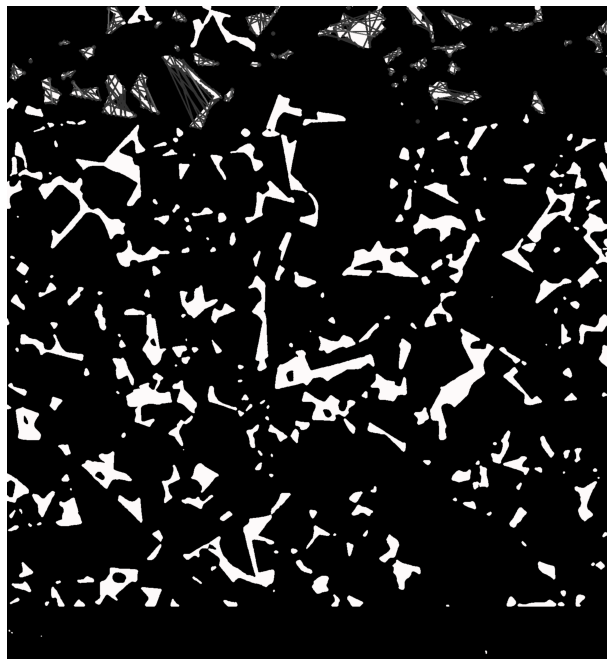

In [57]:
image=image2
radius=6
eps=0.1

img=Image.fromarray(image)
image = ImageOps.expand(img,border=radius,fill='black')
image=np.array(image)


new_nodes=sort_perimetr(image,nodes2[2:50],eps,grain2_corners,radius=radius)

img=draw_edges(image2,new_nodes[2:50],grain2_corners)
img_show(img,cmap='gray',N=12)
name='vals.png'
io.imsave(name,img)

In [49]:
def draw_edges(image,nodes,corners,color=(51,51,51)):
    new_image=copy.copy(image)
    
    im = Image.fromarray(np.uint8(cm.gist_earth(new_image)*255))
    draw = ImageDraw.Draw(im)
    for j,node in enumerate(nodes):
        if len(node)>1:
         #   print('i=',j)
        #    print(node)
            point1=corners[node[0]][0]
            x1,y1=point1[0],point1[1]
            x_start,y_start=point1[0],point1[1]
            r1=5
            r=3
            draw.ellipse((y1-r1,x1-r1,y1+r1,x1+r1), fill=color, width=10)
            len_node=node[-1]
       #     print(node[:len_node])
            for i,point in enumerate(node[: len_node]):
                point2=corners[point][0]
                x2,y2=point2[0],point2[1]

                draw.ellipse((y2-r,x2-r,y2+r,x2+r), fill=color, width=4)
                draw.line((y1,x1,y2,x2), fill=color, width=4)
                x1,y1=x2,y2
                
            draw.line((y_start,x_start,y1,x1), fill=(100,100,100), width=4)
        else:
            continue

    img=np.array(im)

    return  img
        

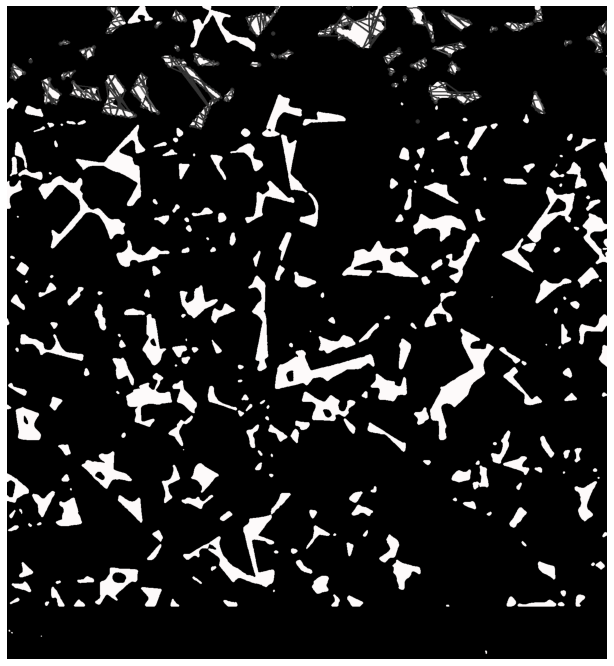

In [50]:
img=draw_edges(image2,new_nodes[2:50],grain2_corners)
img_show(img,cmap='gray',N=12)
name='vals.png'
io.imsave(name,img)

In [ ]:
%%cython -a
cimport numpy as np
import numpy as np

import copy
from scipy.spatial import distance
cimport cython

from libc.time cimport time
from libc.math cimport exp

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
@cython.cdivision(True)
cdef max_dist_points(np.ndarray[np.int, ndim=2, negative_indices=False,mode='c'] node,
                     np.ndarray[np.int, ndim=2, negative_indices=False,mode='c'] corners):
    cdef: 
        double max_dist=0
        np.int v1
        np.int v2
        np.ndarray[np.int, ndim=1, negative_indices=False,mode='c'] point1
        np.ndarray[np.int, ndim=1, negative_indices=False,mode='c'] point2
        double dist
    for v1 in node:
        for v2 in node:
            if v1!=v2:
                point1=corners[v1]
                point2=corners[v2]
                dist=distance.euclidean(point1,point2)
                if dist>max_dist:
                    max_dist=dist
                
    return max_dist

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
@cython.cdivision(True)
cdef estimate_edges(np.ndarray[np.int, ndim=2, negative_indices=False,mode='c'] image,
                    float max_dist,
                    np.ndarray[np.int, ndim=1, negative_indices=False,mode='c'] node,
                    np.ndarray[np.int, ndim=2, negative_indices=False,mode='c'] corners,
                    float b,
                    int position,
                    int radius):
    # вычисление расстояния и среднего значения между 
    # точкой с индексом posion и остальными точками пустоты
    cdef:
        np.int v1=node[position]
        np.int v2,i
        np.ndarray vals = np.zeros((len(node),2), dtype=np.double)
        np.ndarray[np.int, ndim=1, negative_indices=False,mode='c'] point1
        np.ndarray[np.int, ndim=1, negative_indices=False,mode='c'] point2
        
    if v1!=0:
        for i,v2 in enumerate(node):

            if v2!=0 and v1!=v2  :
                vals[i,0]=v2
                point1=corners[v1]
                point2=corners[v2]
                k=mean_pixel(image,max_dist,point1[0],point2[0],radius,b=b)
                vals[i,1]=k
    return vals
        
def mean_pixel(image,max_dist,point1,point2,r,b):
    val=0
    num=0
    x1,y1=point1[0],point1[1]
    x2,y2=point2[0],point2[1]

    # идем всегда из х1 в х2, сверху вниз
    if x1>x2:
        x1,y1,x2,y2=x2,y2,x1,y1

    y_lin=[]
    x_lin=range(x1,x2)
    # проведем линию и сохраним ее координаты
    for xi in x_lin:
        y_lin.append(round(((xi-x1)/(x2-x1))*(y2-y1)+y1))
    # координатная ось повернута на -90 градусов
    # новый х=-y, новый y=x

    x_lin=np.array(x_lin,dtype='int64')
    y_lin=np.array(y_lin,dtype='int64')
    for xi,yi in zip(y_lin,x_lin):
        for x in range(xi-r,xi+r):
            for y in range(yi-r,yi+r):

                val+=image[y,x]
                num+=1
    if num!=0 and val!=0:
        pix_mean=(val/num)/255
        
        mean=1-abs(pix_mean-0.5)*2
        dist=1-distance.euclidean(point1,point2)/max_dist
        
        f=abs(1-(1+b*b)*mean*dist/(mean*b*b+dist))
    else:
        f=1
        
    return f

def sort_perimetr(image,nodes,corners,b,radius=5):
    new_nodes=np.zeros(nodes.shape,dtype='int64')
    
    # проходим по каждой пустоте
    for i,orig_node in enumerate(nodes):
    # node - пустота
        v1_index=0
        v1=orig_node[v1_index] # фиксируем первый угол и затем будем считать относительно него
        step=1
        new_nodes[i,0]=v1
        flag=True
        orig_node_len=orig_node[-1]
        node=list(copy.copy(orig_node[:orig_node_len]))
        max_dist=max_dist_points(node,corners)
        print('i=',i, ' max=',orig_node.shape[0])
      #  print('-------------')

        if v1!=0 and len(node)>1:
            while flag:

                vals=estimate_edges(image,max_dist,node,corners,position=v1_index,radius=radius,b=b)
                non_zero_indeces=np.where((vals[:,0][:orig_node_len]!=0) )[0]
                vals=vals[non_zero_indeces]
                min_val=vals.min(axis=0)[1]
                
              #  print('min_val',min_val)
                v2_vals_index=np.where(vals[:,1]==min_val )[0][0]
                v2=vals[v2_vals_index][0]
                v2_index=np.where(node==v2)[0][0]

                new_nodes[i,step]=v2
                node.pop(v1_index)
                
                v1=v2
                v2_index=node.index(v2)
                v1_index=v2_index

                
                step+=1
                if step==orig_node_len:
                    flag=False
               
        else:
            continue
        new_nodes[i,-1]= orig_node_len
    return new_nodes